In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix as conf
from scipy import stats
import math

In [2]:
df_al = pd.read_csv("data/ALQ_I.csv")
df_sm = pd.read_csv("data/SMQ_I.csv")
df_dr = pd.read_csv("data/DUQ_I.csv")

df_dr.replace({999: math.nan}, inplace=True)
df_sm.replace({99999: math.nan}, inplace=True)
df_al.replace({999: math.nan}, inplace=True)

age_cols_dict = {"age_marijuana": "DUQ210", 
                 "age_cocaine": "DUQ260", 
                 "age_heroine": "DUQ300", 
                 "age_meth": "DUQ340", 
                 "age_injected": "DUQ390"}
age_cols_dict = dict([(v,k) for k,v in age_cols_dict.items()])
df_dr.rename(columns=age_cols_dict, inplace=True)

df_sm.rename(columns={"SMQ930": "age_cig"}, inplace=True)

In [3]:
mdf_ad = pd.merge(left=df_al, right=df_dr, left_on='SEQN', right_on="SEQN")
mdf_as = pd.merge(left=df_al, right=df_sm, left_on='SEQN', right_on="SEQN")
mdf_ds = pd.merge(left=df_dr, right=df_sm, left_on='SEQN', right_on="SEQN")

mdf = pd.merge(left=mdf_as, right=df_dr, left_on='SEQN', right_on="SEQN")

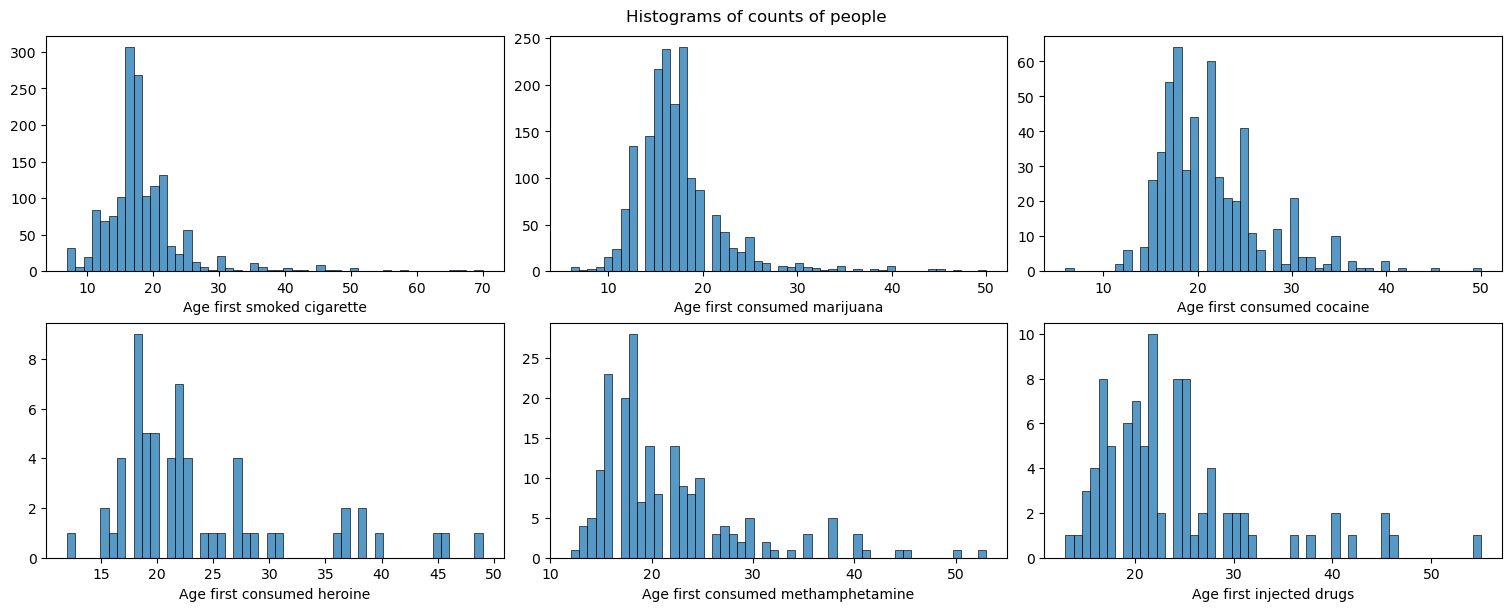

In [39]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 6),
                        layout="constrained")

sns.histplot(df_sm["age_cig"], bins=50, ax=axs[0, 0])
axs[0,0].set_xlabel("Age first smoked cigarette")
axs[0,0].set_ylabel("")
sns.histplot(df_dr["age_marijuana"], bins=50, ax=axs[0, 1])
axs[0,1].set_xlabel("Age first consumed marijuana")
axs[0,1].set_ylabel("")
sns.histplot(df_dr["age_cocaine"], bins=50, ax=axs[0, 2])
axs[0,2].set_xlabel("Age first consumed cocaine")
axs[0,2].set_ylabel("")
sns.histplot(df_dr["age_heroine"], bins=50, ax=axs[1, 0])
axs[1,0].set_xlabel("Age first consumed heroine")
axs[1,0].set_ylabel("")
sns.histplot(df_dr["age_meth"], bins=50, ax=axs[1, 1])
axs[1,1].set_xlabel("Age first consumed methamphetamine")
axs[1,1].set_ylabel("")
sns.histplot(df_dr["age_injected"], bins=50, ax=axs[1, 2])
axs[1,2].set_xlabel("Age first injected drugs")
axs[1,2].set_ylabel("")
fig.suptitle("Histograms of counts of people")
plt.savefig("viz1.pdf")
plt.show()

In [61]:
def count_range(minval, maxval, col):
    return ( (col < maxval) & (col>=minval) ).sum()
    
def get_counts_range(col, bin_size):
    return [count_range(i, i+bin_size, col) for i in range(0, int(col.max()), bin_size)]

def get_percent_range(col, bin_size):
    return [100*count_range(i, i+bin_size, col)/col.count() for i in range(0, int(col.max()), bin_size)]

BIN_SIZE = 10
age_df = pd.DataFrame([get_counts_range(df_sm["age_cig"], BIN_SIZE)] + 
                      [get_counts_range(df_dr[col], BIN_SIZE) for col in age_cols_dict.values()])
age_df["substance"] = ["age_cigarette"] + list(age_cols_dict.values())
age_df.columns = [f"{i*BIN_SIZE}-{(i+1)*BIN_SIZE}" for i in range(age_df.shape[1]-1)] + ["substance"]
age_df.fillna(0, inplace=True)
age_df["substance"] = age_df.substance.apply( (lambda x: x.split("_")[-1]))
age_df = pd.melt(age_df, id_vars="substance", var_name="age_range", value_name="counts")
age_df.counts = age_df.counts.astype(np.int32)


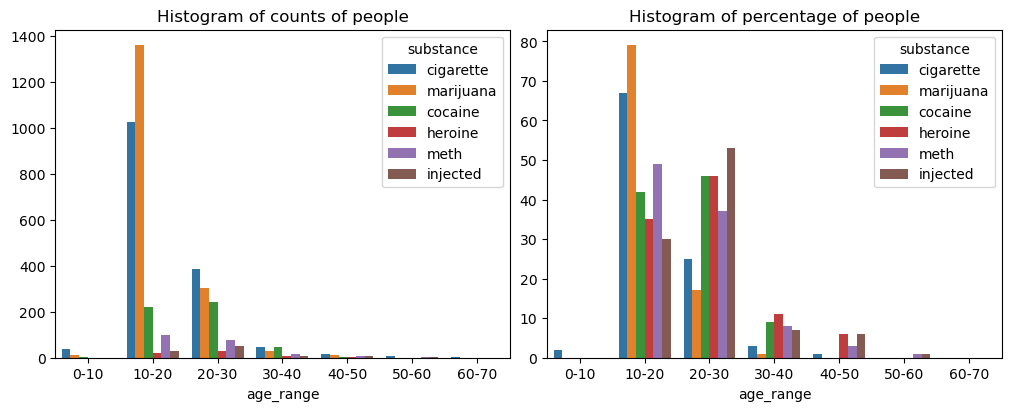

In [62]:
BIN_SIZE = 10
age_df_p = pd.DataFrame([get_percent_range(df_sm["age_cig"], BIN_SIZE)] + 
                      [get_percent_range(df_dr[col], BIN_SIZE) for col in age_cols_dict.values()])
age_df_p["substance"] = ["age_cigarette"] + list(age_cols_dict.values())
age_df_p.columns = [f"{i*BIN_SIZE}-{(i+1)*BIN_SIZE}" for i in range(age_df_p.shape[1]-1)] + ["substance"]
age_df_p.fillna(0, inplace=True)
age_df_p["substance"] = age_df_p.substance.apply( (lambda x: x.split("_")[-1]))
age_df_p = pd.melt(age_df_p, id_vars="substance", var_name="age_range", value_name="counts")
age_df_p.counts = age_df_p.counts.astype(np.int32)


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

sns.barplot(data=age_df, x="age_range", y="counts", hue="substance", ax=axs[0])
axs[0].set_ylabel("")
axs[0].set_title('Histogram of counts of people')

sns.barplot(data=age_df_p, x="age_range", y="counts", hue="substance", ax=axs[1])
axs[1].set_ylabel("")
axs[1].set_title('Histogram of percentage of people')

plt.savefig("viz2.pdf")
plt.show()


In [7]:

mdf.SMQ925.replace({2: False, 1: True, 7: False, 9: False}, inplace=True)
mdf.ALQ110.replace({2: False, 1: True, 7: False, 9: False}, inplace=True)

mdf.DUQ240.replace({2: False, 1: True, 7: False, 9: False}, inplace=True)
mdf.DUQ200.replace({2: False, 1: True, 7: False, 9: False}, inplace=True)
mdf.DUQ200.fillna(False, inplace=True)

did_drugs = mdf.DUQ200 | mdf.DUQ240

did_cigs = mdf.SMQ925
did_alc = mdf.ALQ110

new_df = pd.DataFrame([])
new_df["drugs"] = did_drugs
new_df["cigarettes"] = did_cigs
new_df["alcohol"] = did_alc

new_df.dropna(inplace=True)

did_cigs = new_df.cigarettes
did_alc = new_df.alcohol
did_drugs = new_df.drugs

did_alc_drugs = did_alc & did_drugs
did_alc_cigs = did_alc & did_cigs
did_cigs_drugs = did_cigs & did_drugs

did_all = did_alc & did_cigs_drugs

[202, 35, 33, 105, 118, 22, 53]


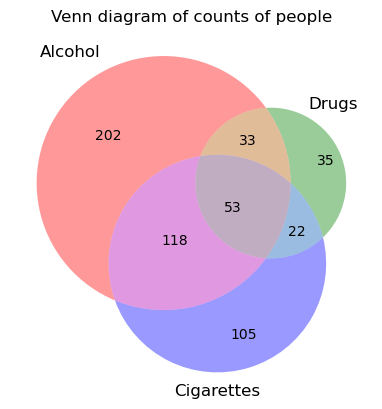

In [47]:
# ! conda install -c conda-forge matplotlib-venn -y
from matplotlib_venn import venn3

set1 = set(['A', 'B', 'C'])
set2 = set(['A', 'B', 'D'])
set3 = set(['A', 'E', 'F'])

alc_only = did_alc.sum() - did_alc_drugs.sum() - did_alc_cigs.sum() + did_all.sum()
cigs_only = did_cigs.sum() - did_cigs_drugs.sum() - did_alc_cigs.sum() + did_all.sum()
drugs_only = did_drugs.sum() - did_alc_drugs.sum() - did_cigs_drugs.sum() + did_all.sum()

alc_drugs = did_alc_drugs.sum() - did_all.sum()
alc_cigs = did_alc_cigs.sum() - did_all.sum()
cigs_drugs = did_cigs_drugs.sum() - did_all.sum()

venn_data = [alc_only, drugs_only, alc_drugs, cigs_only, alc_cigs, cigs_drugs, did_all.sum()]
print(venn_data)
venn3(venn_data, ('Alcohol', 'Drugs', 'Cigarettes'))
plt.title("Venn diagram of counts of people")
plt.savefig("viz3.pdf", bbox_inches='tight')

plt.show()

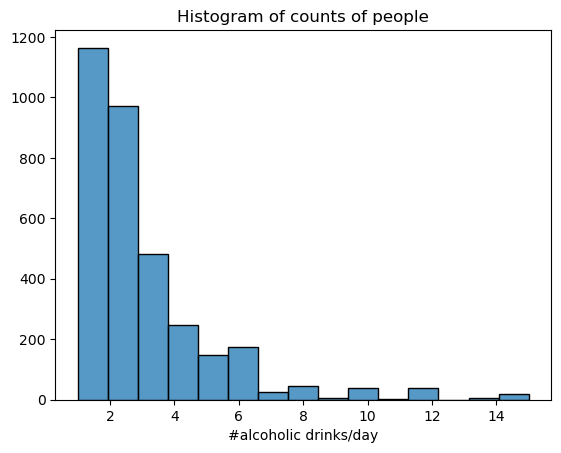

In [48]:
df_al.rename(columns={"ALQ130": "#alcoholic drinks/day"}, inplace=True)
sns.histplot(df_al["#alcoholic drinks/day"], bins=15)
plt.ylabel("")
plt.title("Histogram of counts of people")
plt.savefig("viz4.pdf")

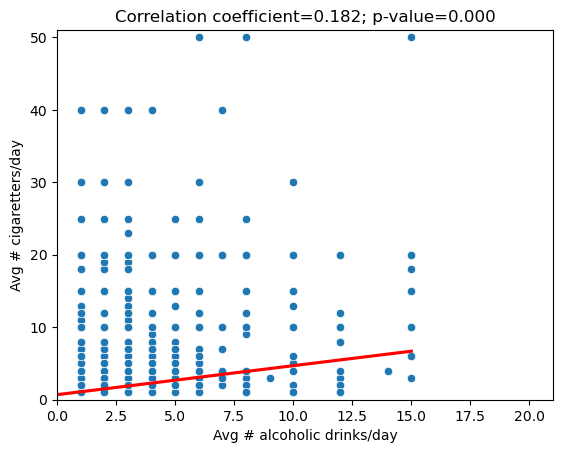

PearsonRResult(statistic=0.18198600028943618, pvalue=2.468005362678055e-37)

In [77]:
a = list(map(lambda x: -1 if (math.isnan(x) or x==999) else x, mdf.ALQ130.to_numpy()))
s = list(map(lambda x: -1 if (math.isnan(x) or x==999) else x, mdf.SMD650.to_numpy()))
plt.ylim(0, 51)
plt.xlim(0, 21)
sns.scatterplot(x=a, y=s)
sns.regplot(x=a, y=s, ci= None, color='red', scatter=False)
plt.xlabel("Avg # alcoholic drinks/day")
plt.ylabel("Avg # cigaretters/day")
corr, p = stats.pearsonr(a, s)
plt.title(f"Correlation coefficient={corr:.3f}; p-value={p:.3f}")
plt.savefig("viz5.pdf", bbox_inches='tight')
plt.show()
stats.pearsonr(a, s)

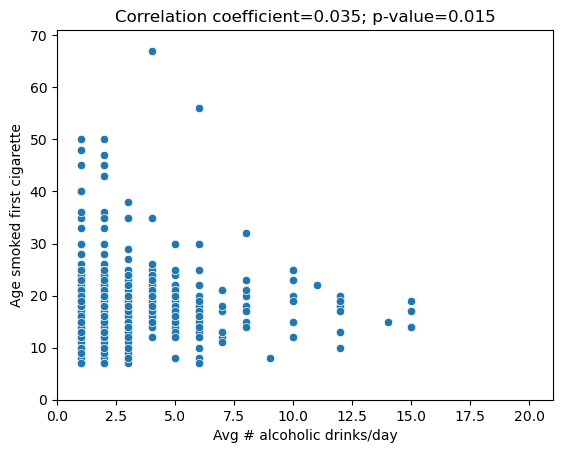

In [78]:
a = list(map(lambda x: -1 if (math.isnan(x) or x==999) else x, mdf.ALQ130.to_numpy()))
s = list(map(lambda x: -1 if (math.isnan(x) or x==999) else x, mdf.age_cig.to_numpy()))
plt.ylim(0, 71)
plt.xlim(0, 21)
sns.scatterplot(x=a, y=s)
# sns.regplot(x=a, y=s, ci= None, color='red', scatter=False)
plt.xlabel("Avg # alcoholic drinks/day")
plt.ylabel("Age smoked first cigarette")
corr, p = stats.pearsonr(a, s)
plt.title(f"Correlation coefficient={corr:.3f}; p-value={p:.3f}")
plt.savefig("viz6.pdf", bbox_inches='tight')
plt.show()


# Linear Regression

In [79]:
newdf = mdf[['age_marijuana', 'age_cig']].dropna()
X = sm.add_constant(newdf.age_marijuana)
stats = sm.OLS(newdf.age_cig, X).fit()
print("AIC =", stats.aic)
stats.summary()


AIC = 2711.9242755463547


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                age_cig   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     36.61
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           2.88e-09
Time:                        02:29:09   Log-Likelihood:                -1354.0
No. Observations:                 489   AIC:                             2712.
Df Residuals:                     487   BIC:                             2720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.5783      0.677     20.057      0.000      12.248      14.909
age_marijuana     0.2180      0.036      6.051      0.000       0.147       0.289
==============================================================================
Omnibus:                      160.944   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1283.760
Skew:                           1.198   Prob(JB):                    1.72e-279
Kurtosis:                      10.567   Cond. No.                         73.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
new_df_now = mdf[['age_marijuana', 'age_cig']].dropna()
new_df_now

,age_marijuana,age_cig
5,18.0,18.0
7,18.0,19.0
22,20.0,22.0
36,18.0,22.0
46,14.0,18.0
...,...,...
4785,16.0,16.0
4801,28.0,19.0
4804,21.0,21.0
4817,17.0,18.0


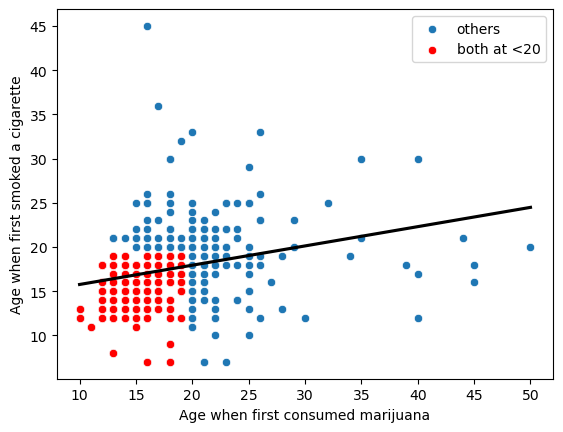

In [91]:
newdf1 = newdf[(newdf.age_marijuana<20) & (newdf.age_cig<20)]
newdf2 = newdf[(newdf.age_marijuana>=20) & (newdf.age_cig>=20) & (newdf.age_marijuana<30) & (newdf.age_cig<30)]
newdf3 = newdf[(newdf.age_marijuana>=30) & (newdf.age_cig>=30) & (newdf.age_marijuana<40) & (newdf.age_cig<40)]
newdf4 = newdf[(newdf.age_marijuana>=40) & (newdf.age_cig>=40)]

sns.scatterplot(x=newdf.age_marijuana, y=newdf.age_cig, label='others')
sns.scatterplot(x=newdf1.age_marijuana, y=newdf1.age_cig, color='r', label='both at <20')
# sns.scatterplot(x=newdf2.age_marijuana, y=newdf2.age_cig, label='both at 20-30')
# sns.scatterplot(x=newdf3.age_marijuana, y=newdf3.age_cig, label='both at 30-40')
# sns.scatterplot(x=newdf4.age_marijuana, y=newdf4.age_cig, label='both at >40')
sns.regplot(x=newdf.age_marijuana, y=newdf.age_cig, ci=None, scatter=False, color="k")
plt.xlabel("Age when first consumed marijuana")
plt.ylabel("Age when first smoked a cigarette")
plt.savefig('lin1s.pdf')

## Linear regression 2

In [94]:
mdf_l1 = mdf[~(mdf.ALQ130.isna())].rename(columns={'ALQ130': '#alcoholic drinks/day', 'DUQ219': '#joints/day'})

# days_smoked = mdf_l1.SMD641.replace(99, mdf_l1.SMD641.median())
# num_cigs = mdf_l1.SMD650.replace(999, mdf_l1.SMD650.median())
# num_cigs.fillna(num_cigs.median(), inplace=True)
# total_cigs = num_cigs*days_smoked/30

alcohol = mdf_l1['#alcoholic drinks/day']
joints = mdf_l1['#joints/day'].fillna(0).replace(7, 0).replace(9, 0).replace(3, 5).replace(4, 8)

X = sm.add_constant(alcohol)
stats = sm.OLS(joints, X).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            #joints/day   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     102.1
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.24e-23
Time:                        03:11:52   Log-Likelihood:                -5366.4
No. Observations:                2968   AIC:                         1.074e+04
Df Residuals:                    2966   BIC:                         1.075e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3174      0.042      7.550      0.000       0.235       0.400
#alcoholic drinks/day     0.1133      0.011     10.107      0.000       0.091       0.135
==============================================================================
Omnibus:                     1781.427   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13650.850
Skew:                           2.872   Prob(JB):                         0.00
Kurtosis:                      11.798   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
stats.aic

10736.717634717827

<AxesSubplot:xlabel='DUQ219', ylabel='ALQ130'>

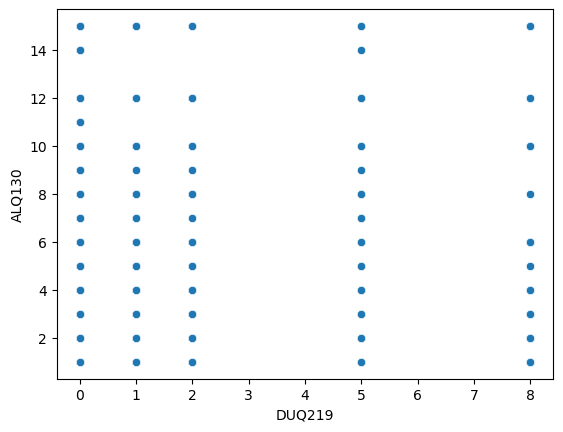

In [17]:
sns.scatterplot(x=joints, y=alcohol)

# Logistic regression

In [19]:
mdf.rename(columns={'DUQ200': 'ever_did_drugs', 'ALQ151': 'ever_had_5_drinks', 'SMQ925': 'ever_smoked'},
           inplace=True)
model = sm.GLM.from_formula("ever_did_drugs ~ ever_had_5_drinks + ever_smoked", data=mdf,
                            family=sm.families.Binomial())
res = model.fit()
print("AIC =", res.aic)
mstats = pd.DataFrame(np.exp(res.params), columns=['OddsRatio'])
mstats['P>|z|'] = res.pvalues
mstats[['2.5%', '97.5%']] = np.exp(res.conf_int())
print(mstats)


AIC = 2391.7676389662142
                     OddsRatio         P>|z|      2.5%     97.5%
Intercept             1.231183  5.722397e-01  0.598221  2.533864
ever_smoked[T.True]   0.392986  9.569970e-21  0.323047  0.478068
ever_had_5_drinks     1.559316  1.670920e-02  1.083718  2.243635


In [ ]:
# newdf = mdf[['DUQ430', 'SMQ670']].dropna() - 1
# model = sm.GLM.from_formula("DUQ430 ~ SMQ670", data=newdf, family=sm.families.Binomial())
# res = model.fit()
# print("AIC =", res.aic)
# mstats = pd.DataFrame(np.exp(res.params), columns=['OddsRatio'])
# mstats['P>|z|'] = res.pvalues
# mstats[['2.5%', '97.5%']] = np.exp(res.conf_int())
# print(mstats)
# res.summary()